In [ ]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
#|default_exp agents.ddpg

In [ ]:
#|export
# Python native modules
import os
from typing import *
from copy import deepcopy
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch import nn
import torch
from  torchdata.dataloader2.graph import DataPipe,traverse
import numpy as np
import pandas as pd
from torch.optim import AdamW
# Local modules
from fastrl.core import *
from fastrl.torch_core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.data.dataloader2 import *
from fastrl.agents.core import *
from fastrl.memory.experience_replay import ExperienceReplay
from fastrl.learner.core import *
from fastrl.loggers.core import *

# DDPG 
> Deep Deterministic Policy Gradiant for continuous action domains

[(Lillicrap et al., 2016) [DDPG] Continuous Control with Deep Reinforcement Learning](https://arxiv.org/abs/1509.02971) based on the 
DPG algorithm in [(Silver et al., 2014) [DPG] Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf).

DDPG uses an actor-critic architecture and has a similar training / learning paradym to DQNs.

## Model

In [ ]:
#|export
class Critic(Module):
    def __init__(
            self,
            state_sz:int,  # The input dim of the state
            action_sz:int, # The input dim of the actions
            hidden=512,    # Number of neurons connected between the 2 input/output layers
            head_layer:Module=nn.Linear, # Output layer
            activition_fn:Module=nn.ReLU # The activation function
        ):
        # TODO: Add batch normalization
        self.action_sz = action_sz
        self.state_sz = state_sz
        self.layers = nn.Sequential(
            nn.Linear(state_sz+action_sz,hidden),
            activition_fn(),
            head_layer(hidden,1),
        )
    def forward(
            self,
            x:torch.Tensor # A single tensor of shape [Batch,`state_sz`+`action_sz`]
            # A single tensor of shape [B,1] representing the cumulative value estimate of state+action combinations  
        ) -> torch.Tensor: 
        return self.layers(x)

add_docs(
Critic,
"Takes a single tensor of size [B,`state_sz`+`action_sz`] -> [B,1] outputs a 1d tensor repersenting the value",
forward="""Takes in a single tensor of a state tensor and action tensor and output
 the culative value estimates of that state,action combination"""
)

The `Critic` is used by `DDPG` to estimate the state-action pairs and is updated using the 
the Bellman-Equation similarly to DQN/Q-Learning and is represeted by $Q(s,a)$

In [ ]:
torch.manual_seed(0)
critic = Critic(4,2)

state = torch.randn(1,4)
action = torch.randn(1,2)

with torch.no_grad():
    test_eq(
        str(critic(torch.cat((state,action),dim=1))),
        str(tensor([[0.0040]]))
    )

In [ ]:
#|export
class Actor(Module):
    def __init__(self,
                 state_sz:int,  # The input dim of the state
                 action_sz:int, # The output dim of the actions
                 hidden=512,    # Number of neurons connected between the 2 input/output layers
                 head_layer:Module=nn.Linear, # Output layer
                 activition_fn:Module=nn.ReLU # The activiation function
                ):
        # TODO: Add batch normalization
        self.action_sz = action_sz
        self.state_sz = state_sz
        self.layers = nn.Sequential(
            nn.Linear(state_sz,hidden),
            activition_fn(),
            head_layer(hidden,action_sz),
            nn.Tanh()
        )
    def forward(self,x): return self.layers(x)

add_docs(
Actor,
"Takes a single tensor of size [B,`state_sz`] -> [B,`action_sz`] and outputs a tensor of actions.",
forward="""Takes in a state tensor and output
 the actions value mappings"""
)

The `Actor` is used by `DDPG` to predict actions based on state inputs and is represeted by $\mu(s|\theta^\mu)$

In [ ]:
torch.manual_seed(0)
actor = Actor(4,2)

state = torch.randn(1,4)

with torch.no_grad():
    test_eq(
        str(actor(state)),
        str(tensor([[ 0.1430, -0.3305]]))
    )

## Ornstein-Uhlenbeck Exploration

In [ ]:
#|export
class OrnsteinUhlenbeck(dp.iter.IterDataPipe):
	def __init__(
			self, 
			source_datapipe:DataPipe, # a datapipe whose next(source_datapipe) -> `Tensor` 
			action_sz:int, # The action dimension
			mu:float=0., # Used in preturbing continuous actions
			theta:float=0.15, # Used in preturbing continuous actions
			sigma:float=0.2, # Used in preturbing continuous actions
            min_epsilon:float=0.2, # The minimum epsilon to drop to
            # The max/starting epsilon if `epsilon` is None and used for calculating epislon decrease speed.
            max_epsilon:float=1, 
            # Determines how fast the episilon should drop to `min_epsilon`. This should be the number
            # of steps that the agent was run through.
            max_steps:int=100,
            # The starting epsilon which determines how much exploration to do.
			# epislon close to 1 does maximal exploration, while close to 0
			# does very little.
            epsilon:float=None,
            # Based on the `base_agent.model.training`, by default no decrement or step tracking will
            # occur during validation steps.
            decrement_on_val:bool=False,
            # Based on the `base_agent.model.training`, by default random actions will not be attempted
            explore_on_val:bool=False,
            # Also return the original action prior to exploratory noise
            ret_original:bool=False,
            # The device to create the masks one
            device='cpu'
		):
		self.source_datapipe = source_datapipe
		self.min_epsilon = min_epsilon
		self.max_epsilon = max_epsilon
		self.max_steps = max_steps
		self.epsilon = epsilon
		self.decrement_on_val = decrement_on_val
		self.explore_on_val = explore_on_val
		self.ret_original = ret_original
		self.agent_base = None
		self.step = 0
		self.device = torch.device(device)
		self.sigma = sigma
		self.theta = theta
		self.mu = mu
		self.normal_dist = torch.distributions.Normal(0,1)
		self.x = torch.full((action_sz,),1).float().to(device=self.device)
		if not (self.decrement_on_val and self.explore_on_val):
			self.agent_base = find_dp(traverse(self.source_datapipe),AgentBase)

	def __iter__(self):
		for action in self.source_datapipe:
			# TODO: Support tuples of actions also
			if not issubclass(action.__class__,torch.Tensor):
				raise Exception(f'Expected Tensor, got {type(action)}\n{action}')
			if action.dtype not in (torch.float32,torch.float64):
				raise ValueError(f'Expected Tensor of dtype float32,float64, got: {action.dtype} from {self.source_datapipe}')

			if self.decrement_on_val or self.agent_base.model.training:
				self.step+=1
				self.epsilon = max(self.min_epsilon,self.max_epsilon-self.step/self.max_steps)

			# Add a batch dim if missing
			if len(action.shape)==1: action.unsqueeze_(0)

			if self.explore_on_val or self.agent_base.model.training:
				dist = self.normal_dist.sample((len(self.x),)).to(device=self.device)
				self.x += self.theta*(self.mu-self.x)+self.sigma*dist

				if self.ret_original: yield (self.epsilon*self.x+action,action)
				else:                 yield self.epsilon*self.x+action
			else:
				yield action

add_docs(
OrnsteinUhlenbeck,
"""Used for exploration in continuous action domains via temporaly correlated noise.

[1] From https://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

[2] Cumulatively based on [Uhlenbeck et al., 1930](http://www.entsphere.com/pub/pdf/1930%20Uhlenbeck,%20on%20the%20theory%20of%20the%20Brownian%20motion.pdf)"""
)

In [ ]:
#|export
class ExplorationComparisonLogger(LoggerBase):
    def __iter__(self):
        for element in self.source_datapipe:
            if isinstance(element,Record) and element.name=='exploration-compare': 
                self.buffer.append(element)
            elif isinstance(element,tuple) and len(element)==2:
                action,original_action = element
                self.buffer.append(
                    Record(
                        'exploration-compare',
                        tuple((action.detach().cpu(),original_action.detach().cpu()))
                    )
                )
            yield element
    
    def show(self,title='Explored Actions vs Original Actions'):
        import plotly.express as px
        import plotly.io as pio
        pio.renderers.default = "plotly_mimetype+notebook_connected"

        action,original_action = zip(*[o.value for o in self.buffer])
        difference = torch.sub(torch.vstack(action),torch.vstack(original_action)).abs()

        fig = px.scatter(
            pd.DataFrame(difference.numpy()),
            title=title,
            labels={
                "index": "N Steps",
                "value": "Difference between Original/Explored Action"
            },
        )
        return fig.show()

add_docs(
ExplorationComparisonLogger,
"""Allows for quickly doing a "what if" on exploration methods by comparing
the actions selected via exploration with the ones chosen by the model.
""",
show="""Shows the absolute difference between explored actions and original actions.
We would expect as the number of steps increase, the difference between the 
explored and original actions would get smaller. In other words, if there is no
exploration, then the explored actions and the original actions should be almost
identical."""
)

Below we demonstrate that the exploration works. As the number of steps increase,
epsilon will decrease to zero, and so the actions slowly become more deterministic.

In [ ]:
torch.manual_seed(0)

actions = dp.iter.IterableWrapper(
    # Batch of 4 actions with dimensions 2
    torch.randn(4,2)
)

actions = OrnsteinUhlenbeck(
    actions,
    min_epsilon=0,
    max_steps=200,
    action_sz=2,
    decrement_on_val=True,
    explore_on_val=True,
    ret_original=True
)
actions = actions.cycle(count=50)
actions = ExplorationComparisonLogger(actions)
list(actions)
actions.show()

## Agent

In [ ]:
#|export
class ActionUnbatcher(dp.iter.IterDataPipe):
    def __init__(self,source_datapipe):
        self.source_datapipe = source_datapipe

    def __iter__(self):
        for action in self.source_datapipe:
            if len(action.shape)==2: yield action.squeeze(0)
            else:                    yield action

In [ ]:
#|export
def DDPGAgent(
    model:Actor, # The actor to use for mapping states to actions
    # LoggerBases push logs to. If None, logs will be collected and output
    # by the dataloader.
    logger_bases:Optional[LoggerBase]=None, 
    min_epsilon:float=0.2, # The minimum epsilon to drop to
    # The max/starting epsilon if `epsilon` is None and used for calculating epislon decrease speed.
    max_epsilon:float=1, 
    # Determines how fast the episilon should drop to `min_epsilon`. This should be the number
    # of steps that the agent was run through.
    max_steps:int=100,
    # Any augmentations to the DDPG agent.
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None
)->AgentHead:
    agent_base = AgentBase(model,logger_bases=ifnone(logger_bases,[CacheLoggerBase()]))
    agent = StepFieldSelector(agent_base,field='state')
    agent = InputInjester(agent)
    agent = SimpleModelRunner(agent)
    agent = OrnsteinUhlenbeck(
        agent,
        action_sz=model.action_sz,
        min_epsilon=min_epsilon,max_epsilon=max_epsilon,max_steps=max_steps
    )
    
    agent = NumpyConverter(agent)
    agent = ActionUnbatcher(agent)
    agent = AgentHead(agent)
    
    agent = apply_dp_augmentation_fns(agent,dp_augmentation_fns)

    return agent



Check that given a `step`, we can get actions from the `DDPGAgent`...

In [ ]:
torch.manual_seed(0)

actor = Actor(4,2)

agent = DDPGAgent(actor)

input_tensor = tensor([1,2,3,4]).float()
step = SimpleStep(state=input_tensor)

for _ in range(10):
    for action in agent([step]):
        print(action)

[ 0.77837396 -0.11519533]
[ 0.4515079  -0.11048907]
[ 0.40100798 -0.08514518]
[ 0.18760318 -0.15851909]
[-0.07062025  0.09121162]
[-0.10439175  0.08990866]
[-0.19303241  0.034298  ]
[-0.06407389 -0.00715178]
[-0.24715258 -0.15897244]
[-0.07872333 -0.53513074]


In [ ]:
from fastrl.envs.gym import GymTransformBlock
from fastrl.loggers.vscode_visualizers import VSCodeTransformBlock

Creating gif from 100 frames


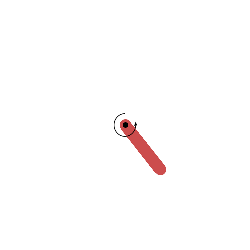

In [ ]:
torch.manual_seed(0)

actor = Actor(3,1)

# Setup the Agent
agent = DDPGAgent(actor,max_steps=10000)

pipe = GymTransformBlock(agent=agent,n=100,seed=None,include_images=True)(['Pendulum-v1'])
pipe = VSCodeTransformBlock()(pipe)

L(pipe);
pipe.show(step=2)

## Learner

In [ ]:
#|export
class BasicOptStepper(dp.iter.IterDataPipe):
    def __init__(self,
        # The parent datapipe that should produce a dict of format `{'loss':tensor(...)}`
        # all other types will be passed through.
        source_datapipe:DataPipe, 
        # The model to attach
        model:nn.Module,
        # The learning rate
        lr:float,
        # The optimizer to use
        opt:torch.optim.Optimizer=AdamW,
        # If an input is loss, catch it and prevent it from proceeding to the
        # rest of the pipeline.
        filter:bool=False,
        # kwargs to be passed to the `opt`
        **opt_kwargs
    ):
        self.source_datapipe = source_datapipe
        self.lr = lr
        self.model = model
        self.opt = opt
        self.opt_kwargs = opt_kwargs
        self.filter = filter
        self._opt = self.opt(self.model.parameters(),lr=self.lr,**self.opt_kwargs)

    def __iter__(self):
        for x in self.source_datapipe:
            if isinstance(x,dict) and 'loss' in x:
                x['loss'].backward()
                self._opt.step()
                self._opt.zero_grad()
                if self.filter: continue 
            yield x

In [ ]:
#|export
class LossCollector(LogCollector):
    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe, likely the one to collect metrics from
            header:str='loss', # Name of the record. Change if using multiple instances.
            # If an input is loss, catch it and prevent it from proceeding to the
            # rest of the pipeline.
            filter:bool=False,
            # By default, LossCollector will search the pipeline for logger bases
            # and attach them here. However we can directly attach them here if
            # we need. This must be a list of lists/queues.
            main_buffers:Optional[List[List]]=None 
        ):
        self.source_datapipe = source_datapipe
        self.main_buffers = main_buffers
        self.header = header
        self.filter = filter
        
    def __iter__(self):
        for x in self.source_datapipe:
            if isinstance(x,dict) and 'loss' in x:
                for q in self.main_buffers: 
                    q.append(Record(self.header,x['loss'].cpu().detach().numpy()))
                if self.filter: continue
            yield x

    def show(self,title='Loss over N-Steps'):
        import plotly.express as px
        import plotly.io as pio
        pio.renderers.default = "plotly_mimetype+notebook_connected"

        losses = {i:[o.value for o in ls] for i,ls in enumerate(self.main_buffers)}

        fig = px.line(
            pd.DataFrame(losses),
            title=title,
            labels={
                "index": "N Steps",
                "value": "Loss"
            },
        )
        return fig.show()

add_docs(
LossCollector,
"""Itercepts dictionary results generated from `source_datapipe` that are in the 
format: `{'loss':tensor(...)}`. All other elements will be ignored and passed through.

If `filter=true`, then intercepted dictionaries will filtered out by this pipe, and will
not be propagated to the rest of the pipeline. 
""",
show="""Shows the loss over n-steps/n-batchs depending on how the loss values are loaded 
into the `main_buffers`. If there is no `LoggerBase`s, then 
`LossCollector(...,main_buffers=[[]],...)` must be passed so that 
losses can be cached for showing."""
)

In [ ]:
#|export
class CriticLossProcessor(dp.iter.IterDataPipe):
    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe that should yield step types
            critic:Critic,
            actor:Actor,
            t_critic:Critic=None,
            loss:nn.Module=nn.MSELoss,
            discount:float=0.99,
            nsteps:int=1
        ):
        self.source_datapipe = source_datapipe
        self.critic = critic
        self.t_critic = ifnone(t_critic,critic)
        self.loss = loss()
        self.actor = actor
        self.discount = discount
        self.nsteps = nsteps

    def __iter__(self) -> Union[Dict,SimpleStep]:
        for batch in self.source_datapipe:
            done_mask = batch.terminated.reshape(-1,)
            with torch.no_grad():
                t_actions = self.actor(batch.next_state)
                q = self.t_critic(torch.hstack((batch.next_state,t_actions)))
                q[done_mask] = 0
            targets = batch.reward+q*(self.discount**self.nsteps)
            pred = self.critic(torch.hstack((batch.state,batch.action)))
            yield {'loss':self.loss(pred,targets)}
            yield batch

In [ ]:
from fastrl.pipes.iter.nstep import NStepFlattener

In [ ]:
pipe = GymTransformBlock(agent=None,n=1000,bs=10)(['Pendulum-v1'])
pipe = StepBatcher(pipe)
steps = list(pipe);

actor = Actor(3,1)
critic = Critic(3,1)

opt = AdamW(critic.parameters(),lr=0.01)

pipe = CriticQProcessor(pipe,critic,actor,deepcopy(critic))

pipe_loss = LossCollector(pipe,main_buffers=[[]])
pipe = BasicOptStepper(pipe_loss,critic,0.01)
list(pipe)
pipe_loss.show()

In [ ]:
#|export
class ActorLossProcessor(dp.iter.IterDataPipe):
    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe that should yield step types
            critic:Critic,
            actor:Actor,
            t_critic:Critic=None,
            loss:nn.Module=nn.MSELoss,
            discount:float=0.99,
            nsteps:int=1
        ):
        self.source_datapipe = source_datapipe
        self.critic = critic
        self.t_critic = ifnone(t_critic,critic)
        self.loss = loss()
        self.actor = actor
        self.discount = discount
        self.nsteps = nsteps

    def __iter__(self) -> Union[Dict,SimpleStep]:
        for batch in self.source_datapipe:
            done_mask = batch.terminated.reshape(-1,)
            with torch.no_grad():
                t_actions = self.actor(batch.next_state)
                q = self.t_critic(torch.hstack((batch.next_state,t_actions)))
                q[done_mask] = 0
            targets = batch.reward+q*(self.discount**self.nsteps)
            pred = self.critic(torch.hstack((batch.state,batch.action)))
            yield {'loss':self.loss(pred,targets)}
            yield batch

In [ ]:
#|export
def DDPGLearner(
    actor,
    critic,
    dls,
    logger_bases=None,
    loss_func=nn.MSELoss(),
    opt=AdamW,
    lr=0.001,
    bs=128,
    max_sz=10000,
    nsteps=1,
    device=None,
    batches=None,
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None
) -> LearnerHead:
    learner = LearnerBase([actor,critic],dls,batches=batches,loss_func=loss_func)
    learner = LoggerBasePassThrough(learner,logger_bases)
    learner = BatchCollector(learner,batch_on_pipe=LearnerBase)
    learner = EpocherCollector(learner)
    for logger_base in L(logger_bases): learner = logger_base.connect_source_datapipe(learner)
    if logger_bases: 
        learner = RollingTerminatedRewardCollector(learner)
        learner = EpisodeCollector(learner)
    learner = ExperienceReplay(learner,bs=bs,max_sz=max_sz)
    learner = StepBatcher(learner,device=device)
    learner = learner.fork(buffer_size=1)
    # learner = QCalc(learner)
    # learner = TargetCalc(learner,nsteps=nsteps)
    # learner = LossCalc(learner)
    # learner = ModelLearnCalc(learner)
    # if logger_bases: 
    #     learner = LossCollector(learner)
    learner = LearnerHead(learner)
    
    learner = apply_dp_augmentation_fns(learner,dp_augmentation_fns)
    
    return learner

In [ ]:
#|eval:false
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)

actor = Actor(3,1)
critic = Critic(3,1)

# Setup the Agent
agent = DDPGAgent(actor,[logger_base],max_steps=10000)
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True), # We basically merge 2 steps into 1 and skip. 
    (GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=100,include_images=True),VSCodeTransformBlock())
)
dls = L(block.dataloaders(['Pendulum-v1']*1))
# Setup the Learner
learner = DDPGLearner(action,critic,dls,logger_bases=[logger_base],bs=128,max_sz=20_000,nsteps=2,lr=0.001,
                     batches=1000)
learner.fit(1)
# learner.fit(10)

episode,rolling_reward,epoch,batch
1,None,0,1001


In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()